<a href="https://colab.research.google.com/github/Sithija97/Python-Projects/blob/main/Stage_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import os 

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [ ]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
model_name = "movenet_thunder" #@param ["movenet_thunder", "movenet_lightning"]

if model_name == "movenet_lightning":
  module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/3")
  input_size = 192
elif model_name == "movenet_thunder":
  module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
  input_size = 256
else:
  raise ValueError("Unsupported model name: %s" % model_name)

movenet = module.signatures['serving_default']

In [ ]:
# bat angle calculation method (with two X,Y cordinates - right hand wrist, left hand wrist)

import math

def calculate_bat_angle_right_hand_batsman(flattened):

  left_wrist_X = flattened[9][0]
  left_wrist_Y = flattened[9][1]
  right_wrist_X = flattened[10][0]
  right_wrist_y = flattened[10][1]

  delta_Y = left_wrist_Y - right_wrist_y
  delta_X = left_wrist_X - right_wrist_X

  print("\nbat angle")
  print(abs(math.degrees(math.atan2(delta_X,delta_Y))))

In [ ]:
# common method to calculate angle with three coordinates
import math
 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [ ]:
# method to calculate head possition

def calculate_head_possition(flattened):

  lEye = (format(flattened[1][0], ".2f"))
  rEye = round(flattened[2][0], 2)
  lEar = round(flattened[3][0], 2)
  rEar = round(flattened[4][0], 2)

  print("\nleft eye",(lEye)[:3])
  print("right eye", rEye)
  print("left ear", lEar)
  print("right ear", rEar)

In [ ]:
# calculate pre defined body angles

def calculate_body_angles(flattened):
  
    # shoulder/elbow/wrist
    print("\n top hand")
    print(getAngle((flattened[5][0], flattened[5][1]), (flattened[7][0], flattened[7][1]), (flattened[9][0], flattened[9][1])))

    # shoulder/elbow/wrist
    print("\n bottom hand")
    print(getAngle((flattened[10][0], flattened[10][1]), (flattened[8][0], flattened[8][1]), (flattened[6][0], flattened[6][1])))

    # hip/knee/ancle
    print("\n front leg")
    print(getAngle((flattened[11][0], flattened[11][1]), (flattened[13][0], flattened[13][1]), (flattened[15][0], flattened[15][1])))

    # shoulder/hip/knee (back foot)
    print("\n back")
    print(getAngle((flattened[6][0], flattened[6][1]), (flattened[12][0], flattened[12][1]), (flattened[14][0], flattened[14][1])))

    # hip/knee/ancle
    print("\n back leg")
    print(getAngle((flattened[12][0], flattened[12][1]), (flattened[14][0], flattened[14][1]), (flattened[16][0], flattened[16][1])))


In [ ]:
# kohli = https://www.jamaicaobserver.com/apps/pbcsi.dll/storyimage/JO/20181217/ARTICLE/312179944/AR/0/AR-312179944.jpg
# root = https://static.independent.co.uk/2021/01/24/14/newFile-3.jpg?width=982&height=726&auto=webp&quality=75
# trot = https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Jonathan_Trott.jpg/180px-Jonathan_Trott.jpg
# kohli1 = https://www.pavilionpaar.com/wp-content/uploads/2020/12/EKDA_qVU4AAbnnR.jpg
# wrong = https://i.ytimg.com/vi/GAOw_Hf7b1g/hqdefault.jpg
# bell = https://cdn.wisden.com/wp-content/uploads/2020/05/GettyImages-117023134-scaled-e1590858242407.jpg
# sanga = https://i.pinimg.com/originals/95/33/00/953300570410094ba908909ce4cff145.jpg
# amla = https://i.pinimg.com/564x/96/bb/61/96bb61ecf376eb6d8d57f3e1785a03d0.jpg
# bopara = https://thereversesweep.typepad.com/.a/6a0120a735b61b970b016765948812970b-pi

def main():

  # include new imports
  from google.colab import drive
  # drive.mount('/content/drive')

  import numpy as np
  import pandas as pd 

  shotlist = ['https://www.pavilionpaar.com/wp-content/uploads/2020/12/EKDA_qVU4AAbnnR.jpg']

  for url in shotlist:
    cmd='curl -o input_image.jpeg {} --silent'.format(url)
    os.system(cmd)

    # Load the input image.
    image_path = 'input_image.jpeg'
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.cast(tf.image.resize_with_pad(
      input_image, input_size, input_size), dtype=tf.int32)

    # Run model inference.
    outputs = movenet(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0']

    # print(keypoint_with_scores)
    print('\n')

    # Added - Extracting relevent points from tensor
    print('=============== Extracting relevent points from tensor ===============')

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_overlay)
    _ = plt.axis('off')

    # added from the second function
    tensor = keypoint_with_scores

    # converting the tensor into a numpy
    array = tensor.numpy()

    # convert the numpy array into a list
    array_list = array.tolist()

    # removing extra [] from list 
    flattened = []
    for sublist in array_list: 
      for val in sublist: 
        for n in val: 
          flattened.append(n) 

    # convert list to a pandas dataframe
    df = pd.DataFrame(flattened, columns = ['X-Coord','Y-Coord','Accuracy'])

    print(df)
    print(type(df))

    # calling the bat angle calculation method
    calculate_bat_angle_right_hand_batsman(flattened)

    # calling the body angles calculation method
    calculate_body_angles(flattened)

    # calling the head possition calculation method
    calculate_head_possition(flattened)

    # saving the data into a csv
    x = 1
    df.to_csv('book_'+str(x)+'.csv')
    x=x+1    
    # df.to_csv('Book.csv')
    # df.to_csv('D:/Book2.csv')



=============== Extracting relevent points from tensor ===============
     X-Coord   Y-Coord  Accuracy
0   0.402096  0.717528  0.753524
1   0.387960  0.729047  0.633603
2   0.392879  0.709128  0.753258
3   0.372242  0.711388  0.798954
4   0.379102  0.673504  0.809398
5   0.366686  0.709321  0.626029
6   0.426403  0.624247  0.802394
7   0.363414  0.803926  0.627767
8   0.520297  0.731962  0.576934
9   0.429102  0.897171  0.697531
10  0.489445  0.830096  0.703523
11  0.543571  0.618753  0.679082
12  0.554800  0.530337  0.570802
13  0.560441  0.764525  0.667162
14  0.693600  0.400394  0.857933
15  0.755114  0.719709  0.806060
16  0.766889  0.194322  0.730289
<class 'pandas.core.frame.DataFrame'>

bat angle
41.97533962715611

 top hand
142.8551174393316

 bottom hand
121.4690769772852

 front leg
83.63707047649

 back
173.06943730136524

 back leg
152.69031872672699

left eye 0.3
right eye 0.39
left ear 0.37
right ear 0.38


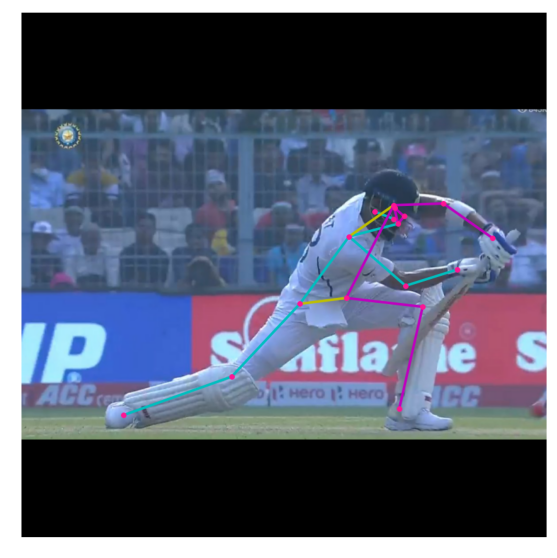

In [ ]:
main()